Features shape: (61, 9000)


/home/wemenes/anaconda3/envs/my-rdkit-env/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


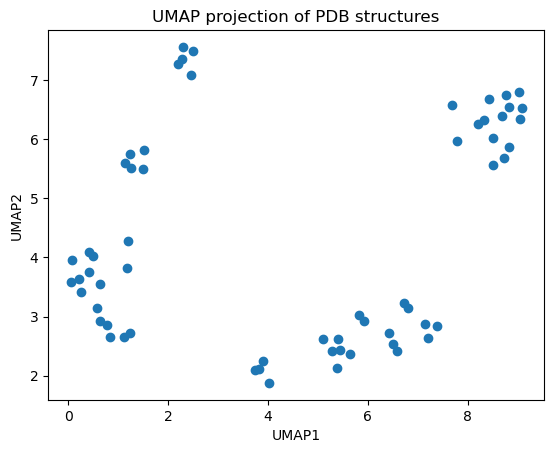

Número de clusters = 2: Coeficiente de Silhouette médio = 0.5661185383796692
Número de clusters = 3: Coeficiente de Silhouette médio = 0.6795178651809692
Número de clusters = 4: Coeficiente de Silhouette médio = 0.7042475938796997
Número de clusters = 5: Coeficiente de Silhouette médio = 0.6611120104789734
Número de clusters = 6: Coeficiente de Silhouette médio = 0.6725082993507385
Número de clusters = 7: Coeficiente de Silhouette médio = 0.7040520310401917
Número de clusters = 8: Coeficiente de Silhouette médio = 0.6758109927177429
Número de clusters = 9: Coeficiente de Silhouette médio = 0.6484113931655884
Número de clusters = 10: Coeficiente de Silhouette médio = 0.6642506122589111


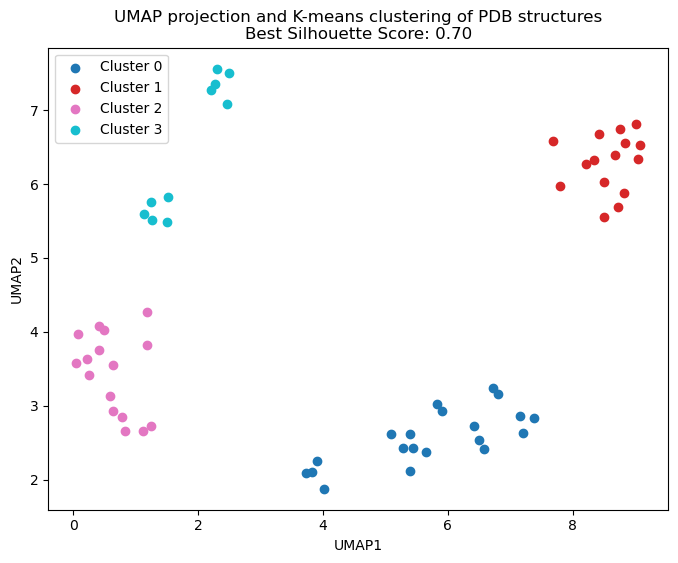

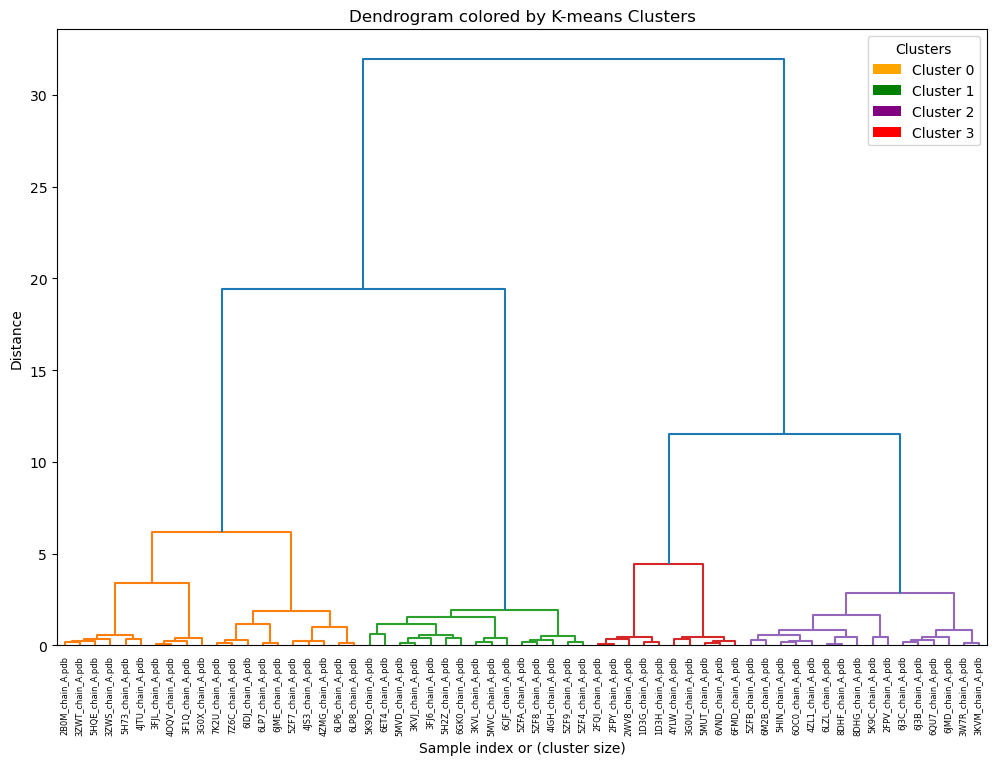

In [ ]:
import os
import numpy as np
from Bio import PDB
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import shutil
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib.patches import Patch

def extract_features_from_pdb(pdb_file, max_atoms=9000, ignore_heteroatoms=True):
    parser = PDB.PDBParser(QUIET=True)
    try:
        structure = parser.get_structure('protein', pdb_file)
        model = structure[0]
        
        atoms = []
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    for atom in residue:
                        atoms.append(atom.get_coord())
        
        atoms = np.array(atoms)
        
        # Truncate or pad the array to a fixed length
        if len(atoms) > max_atoms:
            atoms = atoms[:max_atoms]
        else:
            padding = np.zeros((max_atoms - len(atoms), 3))
            atoms = np.vstack((atoms, padding))
        
        return atoms
    except Exception as e:
        print(f"Error processing {pdb_file}: {e}")
        return None

def extract_features_from_directory(pdb_dir, max_atoms=3000):
    features = []
    pdb_files = [f for f in os.listdir(pdb_dir) if f.endswith('.pdb')]
    
    for pdb_file in pdb_files:
        file_path = os.path.join(pdb_dir, pdb_file)
        atoms = extract_features_from_pdb(file_path, max_atoms)
        if atoms is not None:
            features.append(atoms.flatten())  # Flattening the array
    return np.array(features), pdb_files

def align_structures(structures):
    # Alinhar todas as estruturas à primeira estrutura usando o algoritmo de Kabsch
    reference = structures[0]
    aligned_structures = [reference]  # A primeira estrutura permanece a mesma como referência

    for structure in structures[1:]:
        # Alinhar a estrutura atual à estrutura de referência
        rot, trans = Kabsch(reference, structure)
        aligned_structure = np.dot(structure - trans, rot)
        aligned_structures.append(aligned_structure)

    return aligned_structures

def Kabsch(P, Q):
    """Algoritmo de Kabsch para superposição estrutural."""
    C = np.dot(np.transpose(P), Q)
    V, S, W = np.linalg.svd(C)

    # Calcular a matriz de rotação
    d = np.linalg.det(np.dot(W, V))
    if d < 0:
        W[:, -1] *= -1

    # Calcular a matriz de translação
    translation = np.mean(P, axis=0) - np.mean(np.dot(Q, W), axis=0)

    return W, translation

# Exemplo de uso
pdb_dir = "pdb_files"
features, pdb_files = extract_features_from_directory(pdb_dir)
print(f"Features shape: {features.shape}")

# Normalizar as feições
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Aplicar UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
embedding = reducer.fit_transform(scaled_features)

# Visualizar os resultados da projeção UMAP
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.title("UMAP projection of PDB structures")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

# Testar o coeficiente de silhouette para diferentes números de clusters
range_n_clusters = range(2, 11)
best_silhouette_score = -1
best_clusters = None
best_kmeans = None

for n_clusters in range_n_clusters:
    # Clusterizar com K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embedding)

    # Calcular o coeficiente de silhouette
    silhouette_avg = silhouette_score(embedding, clusters)
    print(f"Número de clusters = {n_clusters}: Coeficiente de Silhouette médio = {silhouette_avg}")

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_clusters = clusters.copy()
        best_kmeans = kmeans

# Visualizar os resultados da melhor clusterização
plt.figure(figsize=(8, 6))

# Plotar os pontos do UMAP com cores dos clusters K-means
for cluster_idx, color in zip(np.unique(best_clusters), plt.cm.tab10(np.linspace(0, 1, len(np.unique(best_clusters))))):
    plt.scatter(embedding[best_clusters == cluster_idx, 0], 
                embedding[best_clusters == cluster_idx, 1], 
                color=color,
                label=f'Cluster {cluster_idx}')

plt.title(f"UMAP projection and K-means clustering of PDB structures\nBest Silhouette Score: {best_silhouette_score:.2f}")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.savefig('UMAP.svg', format='svg')
plt.show()

# Criar dendograma com base nos clusters K-means
linked = linkage(embedding, method='ward')

# Calcular os clusters com base no dendrograma
max_d = 8  # Define o limite de distância para cortar o dendrograma
clusters_dendro = fcluster(linked, max_d, criterion='distance')

# Plotar o dendrograma com cores dos clusters K-means
plt.figure(figsize=(12, 8))
dendro = dendrogram(linked, labels=pdb_files, orientation='top', distance_sort='descending', show_leaf_counts=True, color_threshold=max_d)

# Mapear as cores específicas aos clusters
cores_clusters = {0: 'orange', 1: 'green', 2: 'purple', 3: 'red'}
legend_elements = [Patch(facecolor=cores_clusters[i], label=f'Cluster {i}') for i in cores_clusters]

# Adicionar a legenda ao gráfico
plt.legend(handles=legend_elements, title='Clusters')

plt.title(f'Dendrogram colored by K-means Clusters')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.savefig('Dendograma.svg', format='svg')
plt.show()

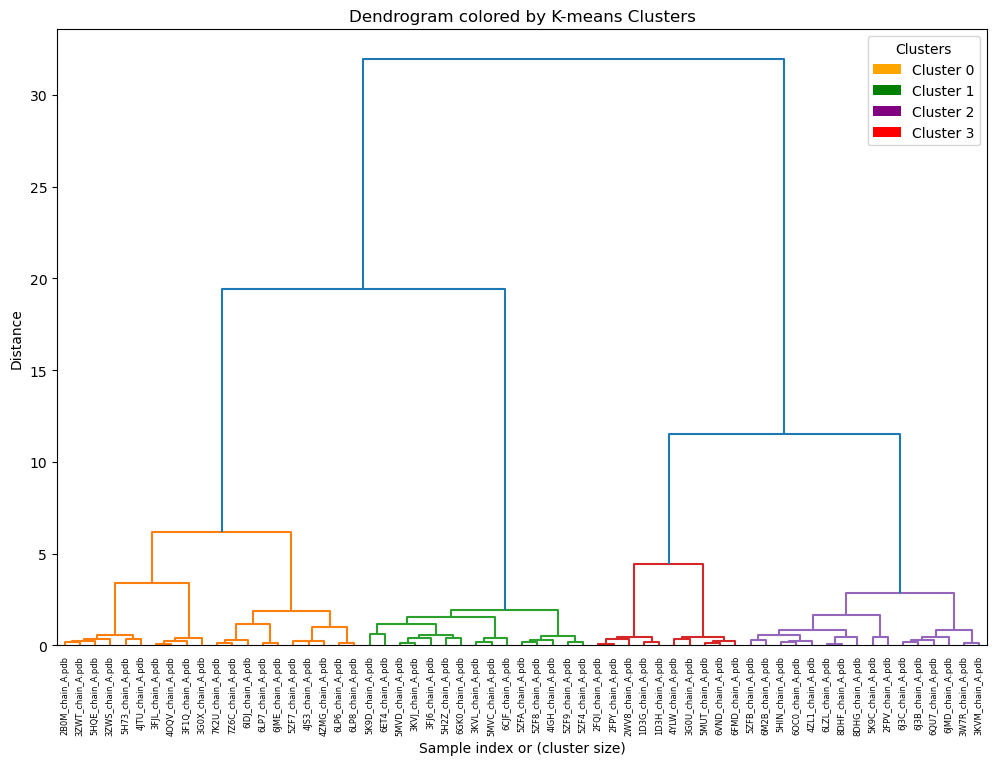

In [8]:
# Plotar o dendrograma com cores dos clusters K-means
plt.figure(figsize=(12, 8))
dendro = dendrogram(linked, labels=pdb_files, orientation='top', distance_sort='descending', show_leaf_counts=True, color_threshold=max_d)

# Mapear as cores específicas aos clusters
cores_clusters = {0: 'orange', 1: 'green', 2: 'purple', 3: 'red'}
legend_elements = [Patch(facecolor=cores_clusters[i], label=f'Cluster {i}') for i in cores_clusters]

# Adicionar a legenda ao gráfico
plt.legend(handles=legend_elements, title='Clusters')

plt.title(f'Dendrogram colored by K-means Clusters')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()

In [ ]:
cluster_centroids = []
for i in range(max(best_clusters) + 1):
    cluster_points = embedding[best_clusters == i]
    centroid = np.mean(cluster_points, axis=0)
    cluster_centroids.append(centroid)

# Encontrar a estrutura mais próxima do centroide de cada cluster
print("\nEstrutura representativa de cada cluster:")
for i, centroid in enumerate(cluster_centroids):
    cluster_points = embedding[best_clusters == i]
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    closest_point_idx = np.argmin(distances)
    closest_pdb_file = pdb_files[np.where(best_clusters == i)[0][closest_point_idx]]
    print(f"Cluster {i}: {closest_pdb_file}")

    src_path = os.path.join(pdb_dir, closest_pdb_file)
    dest_path = os.path.join(pdb_dir, f"cluster_{i}", closest_pdb_file)
    shutil.copy(src_path, dest_path)
    # Plotar o cluster com a estrutura representativa
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[best_clusters == i, 0], embedding[best_clusters == i, 1], c='blue', alpha=0.5, label='Outras estruturas')
    plt.scatter(embedding[np.where(best_clusters == i)[0][closest_point_idx], 0], 
                embedding[np.where(best_clusters == i)[0][closest_point_idx], 1], 
                c='red', label='Estrutura Representativa')
    plt.title(f"Cluster {i}: {closest_pdb_file}")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.legend()
    plt.show()